# Qamomile v0.9.0

---

このリリースでは、新しい `HigherIsingModel` クラス（[#219](https://github.com/Jij-Inc/Qamomile/pull/219)）を導入することで **高次制約なし二値最適化（HUBO: Higher-order Unconstrained Binary Optimization）** 問題のサポートを実現し、Qamomileの最適化機能を大幅に拡張しました。このクラスを用いて、QAOAがphase-gadgetの技術を用いてHUBO問題を扱えるようになり（[#221](https://github.com/Jij-Inc/Qamomile/pull/221)）、従来のQUBO定式化を超えた幅広い最適化問題を量子アルゴリズムで解くことが可能になりました。

また、包括的なCUDA-Qチュートリアルの追加も行いました。詳細については、[リリース](https://github.com/Jij-Inc/Qamomile/releases)や個々のPRをご確認ください。

## ✨ 新機能

### `HigherIsingModel` の導入 ([#219](https://github.com/Jij-Inc/Qamomile/pull/219) および [#225](https://github.com/Jij-Inc/Qamomile/pull/225))

`HigherIsingModel` クラスは、Qamomileに **高次制約なし二値最適化（HUBO: Higher-order Unconstrained Binary Optimization）** 問題のサポートをもたらします。従来のQUBO問題は二次項に制限されていましたが、HUBO問題は任意の次数の相互作用（例：三次、四次、またはそれ以上）を含むことができ、より幅広い最適化シナリオに適用可能です。

`HigherIsingModel` の主な特徴：

- **任意の次数の項**: 線形や二次だけでなく、任意の次数の項を持つIsingモデルをサポート
- **統一されたインターフェース**: 既存の `IsingModel` クラスは現在 `HigherIsingModel` のサブクラスとなり、後方互換性を保ちながら機能を拡張
- **自動インデックス管理**: ユーザーが提供したインデックスを、効率的な量子アルゴリズム実行のためにゼロ始まりの連続インデックスに変換するインデックスマッピングと再インデックス化を内部で処理

高次Isingモデルの数学的定式化：

$$
H = C + \sum_i w_i Z_i + \cdots + \sum_{i_0, \dots, i_k} w_{i_0, \dots, i_k} Z_{i_0}\dots Z_{i_k}
$$

ここで、$Z_i \in \{-1, +1\}$ であり、$w$ は相互作用の強さを表します。

In [1]:
from qamomile.core.ising_qubo import IsingModel
from qamomile.core.higher_ising_model import HigherIsingModel

# 三次項を含むHigherIsingModelを作成
higher_coefficients = {
    (0, 2): -1.5,        # 二次項
    (1, 2): 0.5,         # 二次項
    (0, 1, 2): 2.0,      # 三次項（高次項！）
    (0,): -2.0,          # 線形項
}
constant = 1.0
higher_ising_model = HigherIsingModel(higher_coefficients, constant=constant)

print("三次項を含むHigherIsingModel:")
print(f"係数: {higher_ising_model.coefficients}")
print(f"定数項: {higher_ising_model.constant}")
print(f"変数の数: {higher_ising_model.num_bits}")

# IsingModelは現在HigherIsingModelのサブクラスとなり、後方互換性を提供
quadratic_coefficients = {(0, 1): -0.5}
linear_coefficients = {0: -1.0, 1: 2.0}
ising_model = IsingModel(linear=linear_coefficients, quad=quadratic_coefficients, constant=1.0)

print("\nIsingModel（HigherIsingModelのサブクラス）:")
print(f"coefficients属性を持つか: {hasattr(ising_model, 'coefficients')}")
print(f"係数: {ising_model.coefficients}")
print(f"線形項: {ising_model.linear}")
print(f"二次項: {ising_model.quad}")

三次項を含むHigherIsingModel:
係数: {(0, 2): -1.5, (1, 2): 0.5, (0, 1, 2): 2.0, (0,): -2.0}
定数項: 1.0
変数の数: 3

IsingModel（HigherIsingModelのサブクラス）:
coefficients属性を持つか: True
係数: {(0, 1): -0.5, (0,): -1.0, (1,): 2.0}
線形項: {0: -1.0, 1: 2.0}
二次項: {(0, 1): -0.5}


### HUBO問題を扱えるように `QAOAConverter` を更新 ([#221](https://github.com/Jij-Inc/Qamomile/pull/221))

`HigherIsingModel` の基盤の上に、QAOAは**phase-gadget**技術を使用してHUBO問題を解けるようになりました。Phase-gadgetは、高次項を量子回路に効率的にエンコードし、QAOA実行に適した形式にするための量子回路構成です。

**Phase-Gadgetとは？**

Phase-gadgetは、多量子ビット制御回転を実装する特殊な量子回路です。$Z_i Z_j Z_k$ のような高次項に対して、phase-gadget回路はCNOTゲートとRZゲートを使用して対応する位相回転を実装します。

**主なアップデート：**

- **自動HUBO検出**: `QAOAConverter` は問題がQUBOかHUBOかを自動的に検出
- **Phase-Gadget統合**: 高次項は自動的にphase-gadget回路に変換される
- **シームレスなユーザー体験**: 同じ `QAOAConverter` APIがQUBO問題とHUBO問題の両方で機能

**技術的詳細：**

HUBO instanceに対して `ising_encode()` が呼び出されると、コンバーターは次のように動作します：
1. 問題内の高次項を検出
2. 従来の `IsingModel` の代わりに `HigherIsingModel` を作成
3. QAOAアンザッツ構築時に各高次項用のphase-gadget回路を生成
4. これらを標準的なQAOAミキサーと問題レイヤーと組み合わせる

問題タイプ: HUBO
Isingモデルのタイプ: HigherIsingModel
HUBOサポート: True


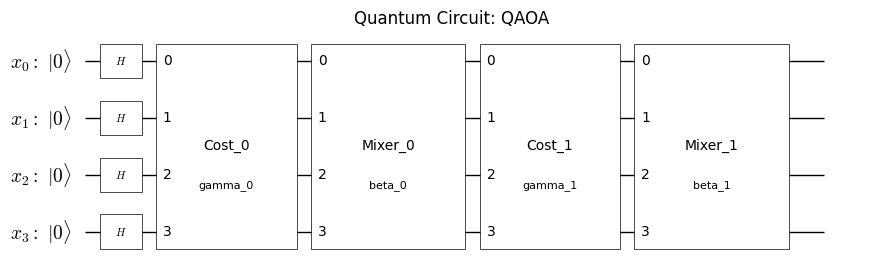

In [2]:
import jijmodeling as jm

from qamomile.core.converters.qaoa import QAOAConverter
from qamomile.core.circuit.drawer import plot_quantum_circuit

# JijModelingを使用して簡単なHUBO問題を定義
# この例では、N体問題を作成します。
N = jm.Placeholder('N')
x = jm.BinaryVar('x',shape=(N,))
i = jm.Element('i', belong_to=(0, N))
problem = jm.Problem('N-body problem')
problem += jm.prod(i, x[i])
problem += jm.sum(i, x[i])

# OMMX instanceにコンパイル
instance_data = {"N": 4}
interpreter = jm.Interpreter(instance_data)
instance= interpreter.eval_problem(problem)

# QAOAに変換 - 今はHUBOをサポート！
qaoa_converter = QAOAConverter(instance)
qaoa_converter.ising_encode()  # 自動的にHUBOを検出し、HigherIsingModelを使用

print(f"問題タイプ: {'HUBO' if not qaoa_converter.is_qubo else 'QUBO'}")
print(f"Isingモデルのタイプ: {type(qaoa_converter.get_ising()).__name__}")
print(f"HUBOサポート: {qaoa_converter._hubo_support}")

# QAOA回路を取得 - phase-gadgetはコストレイヤーに自動的に含まれる
p = 2
qaoa_circuit = qaoa_converter.get_qaoa_ansatz(p=p)
plot_quantum_circuit(qaoa_circuit)

## 🐛 バグ修正

- **デコードエラーの修正** ([#225](https://github.com/Jij-Inc/Qamomile/pull/225), [#218](https://github.com/Jij-Inc/Qamomile/issues/218)): 量子コンバーターにおけるビットから解へのデコードの問題を解決し、結果解釈の精度を向上
- **ドキュメントの修正** ([#229](https://github.com/Jij-Inc/Qamomile/pull/229)): ドキュメントビルドプロセスの更新とレンダリング問題の修正
- **インデックスマッピングの改善** ([#214](https://github.com/Jij-Inc/Qamomile/issues/214)): 問題変数と量子ビット間の正確なマッピングを保証するために、`HigherIsingModel` のインデックス管理を強化

詳細については、[リリース](https://github.com/Jij-Inc/Qamomile/releases)をご確認ください。

## 🛠️ その他の変更と改善

- **CUDA-Qチュートリアル** ([#212](https://github.com/Jij-Inc/Qamomile/pull/212)): NVIDIAの量子コンピューティングプラットフォームであるCUDA-QでQamomileを使用するための包括的な英語および日本語のチュートリアルを追加しました。[CUDA-Q使用チュートリアル](https://jij-inc.github.io/Qamomile/ja/tutorial/usage/cudaq_transpiler_usage.html)をご覧ください！

詳細については、[リリース](https://github.com/Jij-Inc/Qamomile/releases)をご確認ください。

## 💬 フィードバック

`HigherIsingModel` を通じたHUBOサポートとQAOAにおけるphase-gadget技術の導入により、Qamomile v0.9.0は量子アルゴリズムで取り組める最適化問題の範囲を大幅に拡大しました。このリリースにより、Qamomileは量子最適化の研究開発のためのさらに強力で多用途なツールになりました。

従来のQUBO問題に取り組んでいる場合でも、高次最適化の課題を探求している場合でも、Qamomileは複数の量子SDKにアクセスし、古典的ソルバーと結果を比較するための統一されたインターフェースを提供します。

Qamomile v0.9.0をぜひお試しください！フィードバックやバグ報告は、[GitHub Issues](https://github.com/Jij-Inc/Qamomile/issues)にお送りください。